# Denoising Handwritten Digits

This project primarily aims to showcase the practical use of Autoencoders for denoising purposes. Our approach involves introducing Gaussian noise into the MNIST (Modified National Institute of Standards and Technology) dataset and subsequently attempting to remove this noise through the application of various filters such as Gaussian Filter, Bilateral Filter, and Median Filter. However, our main emphasis will be on exploring the effectiveness of **Autoencoders and CNN** in the context of denoising tasks.

### Importing Essential Tools

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from IPython.display import Image, display

In [3]:
from keras.preprocessing import image
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.callbacks import EarlyStopping

### Functions

In [4]:
def normalise(img_arr):
    """
    Rescale pixels values to [0,1]
    """
    img_arr = img_arr.astype("float32")/255
    return img_arr

def add_gnoise(img_arr,factor=0.3):
    """
    Add Gaussian Noise to the array.
    """
    noise = factor * np.random.normal(loc=0.0, scale=1.0, size=img_arr.shape)
    img_arr = img_arr + noise
    img_arr = np.clip(img_arr,0,1)
    return img_arr

def display(orig_arr,noisy_arr,enc_arr,dec_arr):
    """
    Display 5 images (28 x 28) from each of the provided arrays. 
    """
    rows = 4
    cols = 5
    fig, axis = plt.subplots(nrows= rows,ncols= cols, figsize=(5,5))
    
    # Original Representations
    for col in range(cols):
        plt.gray()
        axis[0,col].set_yticks([])
        axis[0,col].set_xticks([])
        axis[0,col].imshow(orig_arr[col].reshape(28,28))
    
    # Noisy Representations
    for col in range(cols):
        plt.gray()
        axis[1,col].set_yticks([])
        axis[1,col].set_xticks([])
        axis[1,col].imshow(noisy_arr[col].reshape(28,28))
    
    # Encoded Representations
    for col in range(cols):
        plt.gray()
        axis[2,col].set_yticks([])
        axis[2,col].set_xticks([])
        axis[2,col].imshow(enc_arr[col].reshape(14,28))   # 392 dimensional encoded representation
        
    # Decoded Representations
    for col in range(cols):
        plt.gray()
        axis[3,col].set_yticks([])
        axis[3,col].set_xticks([])
        axis[3,col].imshow(dec_arr[col].reshape(28,28))
    
    plt.show()

### Data Loading

In [5]:
((X_train,y_train),(X_test,y_test)) = mnist.load_data()

In [6]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [7]:
X_test.shape, y_test.shape

((10000, 28, 28), (10000,))

There are 70,000 images of handwritten digits in the MNIST dataset. Of these 70,000, 60,000 are being used for training and rest 10,000 for testing. Each image is a black and white image with pixel values ranging [0,255]. Each image is 28 x 28 pixels.

### Data Visualisation

<Figure size 640x480 with 0 Axes>

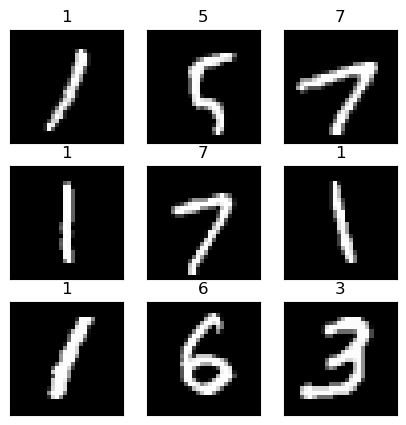

In [8]:
rows = 3
cols = 3

plt.gray()
fig, axis = plt.subplots(nrows=rows,ncols=cols,figsize=(5,5))
count = 99
for row in range(rows):
    for col in range(cols):
        axis[row][col].set_title(y_train[count])
        axis[row][col].set_xticks([])
        axis[row][col].set_yticks([])
        axis[row][col].imshow(X_train[count])
        count = count + 1

### Modelling Convolutional Auto Encoder , Encoder and Decoder

In [9]:
INPUT = Input(shape=(28,28,1))  # 28,28,1 = 784 dim

layer1 = Conv2D(filters=32,kernel_size=(3,3),strides=(1, 1),padding='same',activation="relu")(INPUT)    # 28,28,32
layer2 = MaxPool2D(pool_size=(2, 2),padding='same')(layer1)                               # 14,14,32
layer3 = Conv2D(filters=16,kernel_size=(3,3),strides=(1, 1),padding='same',activation="relu")(layer2)   # 14,14,16
layer4 = MaxPool2D(pool_size=(2, 2),padding='same')(layer3)                               #  7, 7,16

layer5 = Conv2D(filters=8,kernel_size=(3,3),strides=(1, 1),padding='same',activation="relu")(layer4)    #  7, 7, 8  (bottleneck) = 392 dim

layer6 = Conv2DTranspose(filters=16,kernel_size=(3,3),strides=(1, 1),padding='same',activation="relu")(layer5)   #  7, 7, 16
layer7 = UpSampling2D(size=(2, 2))(layer6)                                                                       #  14,14,16
layer8 = Conv2DTranspose(filters=32,kernel_size=(3,3),strides=(1, 1),padding='same',activation="relu")(layer7)   #  14,14,32
layer9 = UpSampling2D(size=(2, 2))(layer8)                                                                       #  28,28,32

layer10 = Conv2D(filters=1,kernel_size=(3,3),strides=(1, 1),padding='same',activation="sigmoid")(layer9)  #  28,28,1 = 784 dim
# Sigmoid, because I will scale the pixel values to [0,1]

# Stacked - Auto Encoder + CNN
autoencoder = Model(INPUT,layer10)

# Encoder
encoder = Model(INPUT,layer5)

In [10]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           1160  

##### Input Output Dimensions Must Match

In [11]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           1160

### Data Processing

In [12]:
NOISE_FACTOR = 0.5

pX_train = normalise(X_train)  # normalise pixels
pX_test  = normalise(X_test)   # normalise pixels

noisy_pX_train = add_gnoise(pX_train)  # noisy processed X_train
noisy_pX_test  = add_gnoise(pX_test)   # noisy processed X_test

In [13]:
X_train.shape,X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [14]:
pX_train.shape,pX_test.shape

((60000, 28, 28), (10000, 28, 28))

In [15]:
noisy_pX_train.shape,noisy_pX_test.shape

((60000, 28, 28), (10000, 28, 28))

### Compiling and Fitting

In [16]:
# Compile 
autoencoder.compile(optimizer="adam",loss="binary_crossentropy",metrics=["mse"])

# Callbacks
callbacks_list = [EarlyStopping(monitor="val_loss",mode="min",patience=10)]

# History and Fit
# Model expects (#, 28,28,1)
history = autoencoder.fit(noisy_pX_train.reshape(len(X_train),28,28,1),pX_train.reshape(len(X_train),28,28,1),
                         batch_size=64,epochs=300,
                         validation_split=0.25,
                         callbacks=callbacks_list)

Epoch 1/300
704/704 [==============================] - 16s 22ms/step - loss: 0.1422 - mse: 0.0261 - val_loss: 0.0953 - val_mse: 0.0107
Epoch 2/300
704/704 [==============================] - 18s 26ms/step - loss: 0.0907 - mse: 0.0094 - val_loss: 0.0887 - val_mse: 0.0086
Epoch 3/300
704/704 [==============================] - 19s 26ms/step - loss: 0.0863 - mse: 0.0080 - val_loss: 0.0860 - val_mse: 0.0078
Epoch 4/300
704/704 [==============================] - 18s 26ms/step - loss: 0.0843 - mse: 0.0074 - val_loss: 0.0845 - val_mse: 0.0073
Epoch 5/300
704/704 [==============================] - 18s 26ms/step - loss: 0.0833 - mse: 0.0070 - val_loss: 0.0837 - val_mse: 0.0071
Epoch 6/300
704/704 [==============================] - 18s 26ms/step - loss: 0.0825 - mse: 0.0068 - val_loss: 0.0830 - val_mse: 0.0068
Epoch 7/300
704/704 [==============================] - 19s 27ms/step - loss: 0.0820 - mse: 0.0066 - val_loss: 0.0825 - val_mse: 0.0066
Epoch 8/300
704/704 [==============================] - 

In [17]:
hist = pd.DataFrame(history.history)
hist

,loss,mse,val_loss,val_mse
0,0.142237,0.026139,0.095299,0.010744
1,0.090661,0.009416,0.088750,0.008627
2,0.086344,0.008024,0.085976,0.007756
3,0.084304,0.007370,0.084494,0.007258
4,0.083259,0.007036,0.083732,0.007056
...,...,...,...,...
131,0.077339,0.005185,0.078501,0.005404
132,0.077310,0.005176,0.078545,0.005415
133,0.077302,0.005174,0.078273,0.005315
134,0.077302,0.005173,0.078244,0.005300


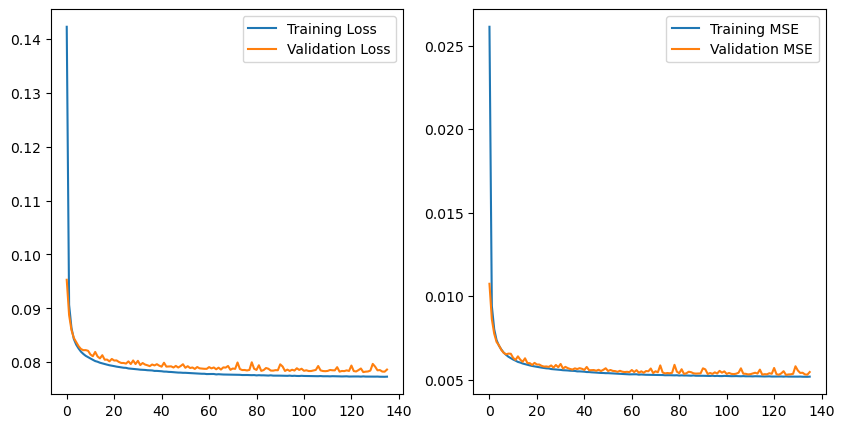

In [18]:
fig, axis = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
axis[0].plot(hist["loss"],label="Training Loss")
axis[0].plot(hist["val_loss"],label="Validation Loss")
axis[0].legend()

axis[1].plot(hist["mse"],label="Training MSE")
axis[1].plot(hist["val_mse"],label="Validation MSE")
axis[1].legend()

### Predictions on Test Set

In [19]:
predictions = autoencoder.predict(noisy_pX_test.reshape(len(X_test),28,28,1))

313/313 [==============================] - 1s 3ms/step


### Displaying Original, Encoded and Decoded Representations for Training Set


* Original Image from MNIST Dataset
* Noisy Image
* Encoded Representation (32 dimensions)
* Decoded Representation

In [20]:
dec_X_train = autoencoder.predict(noisy_pX_train.reshape(len(X_train),28,28,1)) # decoded representations from autoencoder
enc_X_train = encoder.predict(noisy_pX_train.reshape(len(X_train),28,28,1))     # encoded representations from encoder

1875/1875 [==============================] - 2s 1ms/step


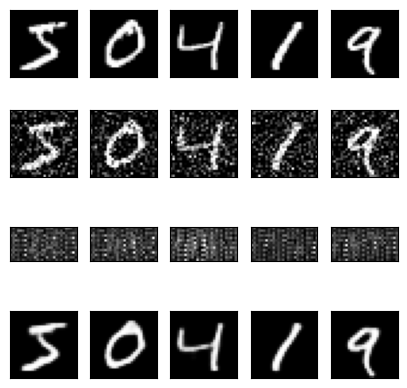

In [21]:
display(pX_train,noisy_pX_train,enc_X_train,dec_X_train);

### Displaying Original, Encoded and Decoded Representations for Test Set

* Original Image from MNIST Dataset
* Noisy Image
* Encoded Representation (32 dimensions)
* Decoded Representation

In [22]:
dec_X_test = autoencoder.predict(noisy_pX_test.reshape(len(X_test),28,28,1))  # decoded representations from autoencoder
enc_X_test = encoder.predict(noisy_pX_test.reshape(len(X_test),28,28,1))      # encoded representations from encoder

313/313 [==============================] - 0s 1ms/step


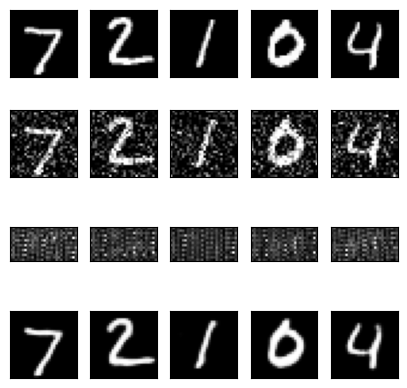

In [25]:
display(pX_test,noisy_pX_test,enc_X_test,dec_X_test);

In [26]:
from keras.models import save_model

In [27]:
save_model(autoencoder,"autoencoder_aecnn.h5")
save_model(encoder,"encoder_aecnn.h5")

/var/folders/cj/hzdf62qj71sdyzsg2kpk9sdw0000gn/T/ipykernel_7611/3054268637.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(autoencoder,"autoencoder_aecnn.h5")
/var/folders/cj/hzdf62qj71sdyzsg2kpk9sdw0000gn/T/ipykernel_7611/3054268637.py:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(encoder,"encoder_aecnn.h5")


In [28]:
hist.to_csv("aecnn_hist.csv",index=False)